In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/ML_DataSets/un-datathon

/content/drive/MyDrive/ML_DataSets/un-datathon


In [4]:
from utils import *
from whales_vessel_strike_risk_assessment import *

Loading datasets...
Loading GeoDatabase...
Layers found: ['GulfofMexicoVesselTracklines2011']
Loading completed.
Reading CSV file.
Reading CSV file.
Reading CSV file.
Loading datasets completed.


In [2]:
pd.set_option('display.max_columns', None)

In [ ]:
df_site_master.head()

,MARU Site ID,New Site #,Sample Rate,Duty Cycle (minutes),Depth (m),Latitude (°),Longitude,Start Analysis Date,End Analysis Date,Total Days
0,HF-1,1,8 kHz,5.25 on / 24.75 off,971.0,27.634000,-91.718330,7/4/10,11/6/10,126.0
1,HF-1,1,8 kHz,5.25 on / 24.75 off,972.0,27.633950,-91.719250,11/8/10,4/26/11,170.0
2,HF-1,1,20 kHz,15 on / 45 off,970.0,27.633950,-91.719420,5/12/11,10/4/11,146.0
3,HF-1,1,20 kHz,15 on / 45 off,965.0,27.635917,-91.724417,11/13/11,2/22/12,102.0
4,HF-2,2,8 kHz,5.25 on / 24.75 off,771.0,27.670000,-91.325330,7/4/10,11/6/10,126.0


###Sample rate  -maximum frequency that can be accurately recorded is half the sample rate , whales have a range of 10 Hz–30 kHz to produce clicks in ICI(0.2-5s)
###5.25 on / 24.75 off	 - 82.5 % when sounds occur not recorded
###Less depth means bacground noise on surafce affcting signals,comromise

##Drop null columns in sitemaster

In [8]:
df_site_master.dropna(inplace=True)
df_site_master.shape

(57, 10)

In [9]:
df_site_master['Portion_time_not_recorded'] = df_site_master['Duty Cycle (minutes)'].apply(calculate_portion_not_recorded)

In [10]:
df_site_master['Sample Rate'] =df_site_master['Sample Rate'].str.replace('kHz','')
df_site_master.rename(columns={'Latitude (°)':'Lat-Bouy'},inplace=True)
df_site_master.rename(columns={'Longitude':'Long-Bouy'},inplace=True)

In [11]:
df_site_master.columns

Index(['MARU Site ID', 'New Site #', 'Sample Rate', 'Duty Cycle (minutes)',
       'Depth (m)', 'Lat-Bouy', 'Long-Bouy', 'Start Analysis Date',
       'End Analysis Date', 'Total Days', 'Portion_time_not_recorded'],
      dtype='object')

In [12]:
cols_requried= [ 'New Site #', 'Sample Rate','Depth (m)', 'Lat-Bouy', 'Long-Bouy', 'Portion_time_not_recorded']
df_site_master_filtered = df_site_master[cols_requried]

In [13]:
df_whalepresence_data["Date"]=pd.to_datetime(df_whalepresence_data["Date"])
df_whalepresence_data['Date'] = df_whalepresence_data['Date'].dt.date

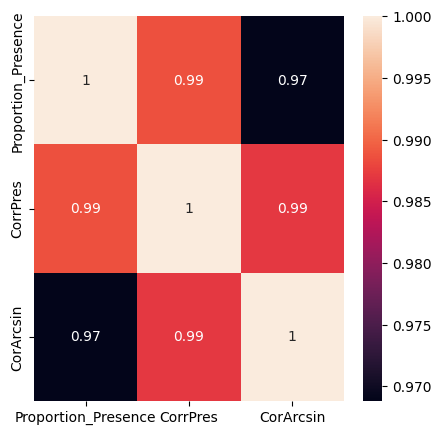

In [16]:
dataplotter = DataPlotter(df_whalepresence_data[["Proportion_Presence","CorrPres","CorArcsin"]])
dataplotter .create_corr_matrix_plot()

##Since hghly correlated keeping only Proportion_Presence

###Since "CorArcsin" is described as the arcsin transformation of the detection performance corrected daily proportion of sperm whale presence, it implies that first the daily proportion is corrected for detection performance to get "CorrPres", and then the arcsine transformation is applied to this corrected proportion.

In [20]:
df_site_master_geo = datareader.transform_to_geodataframe(
    df_site_master_filtered,
    geometry=gpd.points_from_xy(df_site_master_filtered['Long-Bouy'], df_site_master_filtered['Lat-Bouy']),crs= CRS_DEGREE
)

Transforming to GeoDataFrame.


In [ ]:
#df_site_master_geo.to_file("df_site_master_geo.geojson", driver='GeoJSON')

In [22]:
df_site_master_geo.shape

(57, 7)

In [24]:
coordinates = list(zip(df_site_master["Lat-Bouy"].to_list(), df_site_master["Long-Bouy"].to_list()))

bounding_box_with_margin = calculate_bounding_box_with_margin(coordinates,0.2)
print("Bounding Box with Margin:", bounding_box_with_margin)

Bounding Box with Margin: (24.17762, 29.418533, -91.924417, -83.41407)


#Filters only those tracks inside bounding box of the MARU

In [26]:
bbox_polygon = Polygon([
    (bounding_box_with_margin[2], bounding_box_with_margin[0]),
    (bounding_box_with_margin[2], bounding_box_with_margin[1]),
    (bounding_box_with_margin[3], bounding_box_with_margin[1]),
    (bounding_box_with_margin[3], bounding_box_with_margin[0])
])
bbox_gdf = datareader.transform_to_geodataframe(gpd.GeoSeries(bbox_polygon), columns=['geometry'])
bbox_gdf.set_crs(mexico_vessel_tracklines_2011_gdf.crs, inplace=True)

Transforming to GeoDataFrame.


,geometry
0,"POLYGON ((-91.92442 24.17762, -91.92442 29.418..."


In [ ]:
#bbox_gdf.to_file("boundingbox.geojson", driver='GeoJSON')

In [27]:
#df_site_master_geo = df_site_master_geo.to_crs('EPSG:4269')
vessel_tracks_bounded_gdf = gpd.sjoin(mexico_vessel_tracklines_2011_gdf, bbox_gdf, op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
#vessel_tracks_bounded_gdf.to_file("vessel_tracks_bounded_gdf.geojson", driver='GeoJSON')

In [28]:
vessel_tracks_bounded_gdf.shape

(833832, 10)

In [29]:
vessel_tracks_bounded_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

##Get nearrst MARU  for evry vessel Track from centroid

In [31]:
centroids = vessel_tracks_bounded_gdf.geometry.centroid
centroids_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(centroids))
centroids_gdf = centroids_gdf.set_index(vessel_tracks_bounded_gdf.index)
joined_gdf = gpd.sjoin_nearest(
    centroids_gdf,
    df_site_master_geo,
    how="left",
    distance_col="distance"
)

<ipython-input-31-99e7665a5a40>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = vessel_tracks_bounded_gdf.geometry.centroid
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [32]:
# Perform the spatial join to find the nearest point for each centroid
# The 'distance_col' argument adds a column with the distance to the nearest neighbor
joined_gdf = gpd.sjoin_nearest(
    centroids_gdf,
    df_site_master_geo,
    how="left",
    distance_col="distance"
)

# Reset the index to make it a regular column, this column now contains the original 'centroids_gdf' index
joined_gdf.reset_index(inplace=True)

# Sort 'joined_gdf' by the new 'index' column (the original 'centroids_gdf' index) and 'distance'
joined_gdf_sorted = joined_gdf.sort_values(by=['index', 'distance'])

# Drop duplicates based on the new 'index' column to keep only the closest point for each centroid
joined_gdf_deduped = joined_gdf_sorted.drop_duplicates(subset='index')

# Now 'joined_gdf_deduped' should have the same number of records as 'centroids_gdf'

# If you want to remove the 'index' column and revert to the original index
joined_gdf_deduped.set_index('index', inplace=True)
# Optionally, sort the index if needed
joined_gdf_deduped.sort_index(inplace=True)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [33]:
vessel_tracks_bounded_gdf = pd.merge(vessel_tracks_bounded_gdf, joined_gdf_deduped, left_index=True, right_index=True)

In [35]:
vessel_tracks_bounded_gdf.drop(['index_right_x','index_right_y'],inplace=True,axis=1)

In [36]:
vessel_tracks_bounded_gdf.rename(columns={"geometry_x":"geometry"},inplace=True)

In [40]:
vessel_tracks_bounded_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [39]:
vessel_tracks_bounded_gdf = vessel_tracks_bounded_gdf.to_crs(CRS_METER)
vessel_tracks_bounded_gdf['length_in_m'] = vessel_tracks_bounded_gdf["geometry"].length
vessel_tracks_bounded_gdf = vessel_tracks_bounded_gdf.to_crs(CRS_DEGREE)

In [41]:
vessel_tracks_bounded_gdf["time_diff"]= (vessel_tracks_bounded_gdf["TrackEndTime"] - vessel_tracks_bounded_gdf["TrackStartTime"]).dt.total_seconds()

In [42]:
vessel_tracks_bounded_gdf["SOG_mpersecond"]=vessel_tracks_bounded_gdf["length_in_m"]/vessel_tracks_bounded_gdf["time_diff"]

In [43]:
vessel_tracks_bounded_gdf["Date"]=pd.to_datetime(vessel_tracks_bounded_gdf["TrackStartTime"]).dt.date

In [44]:
vessel_tracks_presence_gdf = pd.merge(vessel_tracks_bounded_gdf, df_whalepresence_data, left_on=['Date', 'New Site #'],right_on=['Date','Site_HF'], how='left')

In [45]:
vessel_tracks_presence_gdf.head(1)

,MMSI,TrackStartTime,TrackEndTime,VesselType,Length,Width,maxDraughtMeters,Shape_Length,geometry,geometry_y,...,Day,Year,Season,Region,Site_HF,Hours_Presence,DayHr,Proportion_Presence,CorrPres,CorArcsin
0,1,2011-01-27 18:04:00+00:00,2011-01-27 21:53:00+00:00,70.0,40.0,10.0,5.4,0.035417,"MULTILINESTRING ((-90.23951 29.32810, -90.2412...",POINT (-90.24570 29.34444),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
vessel_tracks_presence_gdf.columns

Index(['MMSI', 'TrackStartTime', 'TrackEndTime', 'VesselType', 'Length',
       'Width', 'maxDraughtMeters', 'Shape_Length', 'geometry', 'geometry_y',
       'New Site #', 'Sample Rate', 'Depth (m)', 'Lat-Bouy', 'Long-Bouy',
       'Portion_time_not_recorded', 'distance', 'length_in_m', 'time_diff',
       'SOG_mpersecond', 'Date', 'Julian_Date', 'Month', 'Day', 'Year',
       'Season', 'Region', 'Site_HF', 'Hours_Presence', 'DayHr',
       'Proportion_Presence', 'CorrPres', 'CorArcsin'],
      dtype='object')

In [47]:
vessel_tracks_presence_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 833832 entries, 0 to 833831
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   MMSI                       833832 non-null  int64              
 1   TrackStartTime             833832 non-null  datetime64[ns, UTC]
 2   TrackEndTime               833832 non-null  datetime64[ns, UTC]
 3   VesselType                 828291 non-null  float64            
 4   Length                     828291 non-null  float64            
 5   Width                      828291 non-null  float64            
 6   maxDraughtMeters           796553 non-null  float64            
 7   Shape_Length               833832 non-null  float64            
 8   geometry                   833832 non-null  geometry           
 9   geometry_y                 833832 non-null  geometry           
 10  New Site #                 833832 non-null  int6

##Impute missing values after join

In [48]:
vessel_tracks_presence_gdf["Hours_Presence"].fillna(0,inplace=True)
vessel_tracks_presence_gdf["CorrPres"].fillna(0,inplace=True)
vessel_tracks_presence_gdf["Region"].fillna("N/A",inplace=True)
vessel_tracks_presence_gdf["Season"].fillna("N/A",inplace=True)
vessel_tracks_presence_gdf["CorArcsin"].fillna(0,inplace=True)
vessel_tracks_presence_gdf["Proportion_Presence"].fillna(0,inplace=True)

##Since replacing by the mode for vessel Type , would replace length and width of vessel of same calss in this case 70

In [49]:
vesseltype_mode=vessel_tracks_presence_gdf["VesselType"].mode()[0]
vessel_mode_df= vessel_tracks_presence_gdf[vessel_tracks_presence_gdf["VesselType"] == vesseltype_mode]

In [50]:
vessel_tracks_presence_gdf["VesselType"].fillna(vesseltype_mode,inplace=True) #replaced mode
vessel_tracks_presence_gdf["Length"].fillna(round(vessel_mode_df["Length"].mean()),inplace=True)  #replaced mean/median , classwise mean
vessel_tracks_presence_gdf["Width"].fillna(round(vessel_mode_df["Width"].mean()),inplace=True)    #replaced mean/median  classwise mean
vessel_tracks_presence_gdf["maxDraughtMeters"].fillna(round(vessel_mode_df["maxDraughtMeters"].mean()),inplace=True) #replaced mean/median

##Feature Engineering on wahle presence and vessel data

In [51]:
vessel_tracks_presence_gdf["Ratio_WhalePresence_by_vesselTime"]= vessel_tracks_presence_gdf["CorrPres"]/(vessel_tracks_presence_gdf["time_diff"]/24*3600)

In [52]:
vessel_tracks_presence_gdf["max_distance_to_find_presence"] = vessel_tracks_presence_gdf.apply(calculate_distance, axis=1).max() # this is degreee, should be in m

In [53]:
vessel_tracks_presence_gdf["max_draught_by_Acoustic"]= (vessel_tracks_presence_gdf["maxDraughtMeters"]- vessel_tracks_presence_gdf["Depth (m)"]).abs()

In [54]:
vessel_tracks_presence_gdf["centroid_vessel_track"]= vessel_tracks_presence_gdf['geometry'].centroid

<ipython-input-54-c325bed40c11>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vessel_tracks_presence_gdf["centroid_vessel_track"]= vessel_tracks_presence_gdf['geometry'].centroid


In [55]:
vessel_tracks_presence_gdf['centroid_longitude'] = vessel_tracks_presence_gdf['centroid_vessel_track'].x
vessel_tracks_presence_gdf['centroid_latitude'] = vessel_tracks_presence_gdf['centroid_vessel_track'].y   ##25th% , 75%quunatiles

In [56]:
vessel_tracks_presence_gdf["DayNumber"]=  vessel_tracks_presence_gdf["TrackStartTime"].dt.day

In [57]:
vessel_tracks_presence_gdf = categorize_time_of_day(vessel_tracks_presence_gdf,"TrackStartTime")

In [60]:
vessel_tracks_presence_gdf['vessel_category'] = vessel_tracks_presence_gdf['VesselType'].astype(str).str[0].astype(int).map(VESSEL_TYPE_MAPPING)
vessel_tracks_presence_gdf['vessel_category'] = vessel_tracks_presence_gdf['vessel_category'].astype('category')

In [61]:
vessel_tracks_presence_gdf[pd.isna(vessel_tracks_presence_gdf['vessel_category'])].head(1)

,MMSI,TrackStartTime,TrackEndTime,VesselType,Length,Width,maxDraughtMeters,Shape_Length,geometry,geometry_y,...,CorArcsin,Ratio_WhalePresence_by_vesselTime,max_distance_to_find_presence,max_draught_by_Acoustic,centroid_vessel_track,centroid_longitude,centroid_latitude,DayNumber,time_of_day,vessel_category


In [62]:
vessel_tracks_presence_gdf.columns

Index(['MMSI', 'TrackStartTime', 'TrackEndTime', 'VesselType', 'Length',
       'Width', 'maxDraughtMeters', 'Shape_Length', 'geometry', 'geometry_y',
       'New Site #', 'Sample Rate', 'Depth (m)', 'Lat-Bouy', 'Long-Bouy',
       'Portion_time_not_recorded', 'distance', 'length_in_m', 'time_diff',
       'SOG_mpersecond', 'Date', 'Julian_Date', 'Month', 'Day', 'Year',
       'Season', 'Region', 'Site_HF', 'Hours_Presence', 'DayHr',
       'Proportion_Presence', 'CorrPres', 'CorArcsin',
       'Ratio_WhalePresence_by_vesselTime', 'max_distance_to_find_presence',
       'max_draught_by_Acoustic', 'centroid_vessel_track',
       'centroid_longitude', 'centroid_latitude', 'DayNumber', 'time_of_day',
       'vessel_category'],
      dtype='object')

In [63]:
final_cols =['vessel_category', 'Length','Width', 'maxDraughtMeters', 'Sample Rate',
       'Depth (m)', 'Lat-Bouy', 'Long-Bouy', 'Portion_time_not_recorded',
       'distance', 'length_in_m', 'time_diff', 'SOG_mpersecond',
        'Season', 'Region', 'Hours_Presence', 'Proportion_Presence', 'Ratio_WhalePresence_by_vesselTime',
       'max_distance_to_find_presence', 'max_draught_by_Acoustic',
       'centroid_longitude', 'centroid_latitude',
       'DayNumber', 'time_of_day']

In [64]:
train_df = vessel_tracks_presence_gdf[final_cols]

In [65]:
train_df.head(1)

,vessel_category,Length,Width,maxDraughtMeters,Sample Rate,Depth (m),Lat-Bouy,Long-Bouy,Portion_time_not_recorded,distance,...,Region,Hours_Presence,Proportion_Presence,Ratio_WhalePresence_by_vesselTime,max_distance_to_find_presence,max_draught_by_Acoustic,centroid_longitude,centroid_latitude,DayNumber,time_of_day
0,Cargo,40.0,10.0,5.4,20,986.0,28.253668,-89.487517,0.75,1.32839,...,N/A,0.0,0.0,0.0,4.112069,980.6,-90.245701,29.344437,27,Evening


##One Hot Encoding

In [66]:
train_df= pd.get_dummies(train_df, columns=train_df.select_dtypes(include=['object', 'category']).columns)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
#le = LabelEncoder()

# Apply LabelEncoder to each object column
#for column in train_df.select_dtypes(include=['object','category']).columns:
#    train_df[column] = le.fit_transform(train_df[column])

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Select numeric columns (integers and floats)
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns

# Apply MinMaxScaler to all numeric columns
train_df[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])


In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833832 entries, 0 to 833831
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Length                             833832 non-null  float64
 1   Width                              833832 non-null  float64
 2   maxDraughtMeters                   833832 non-null  float64
 3   Depth (m)                          833832 non-null  float64
 4   Lat-Bouy                           833832 non-null  float64
 5   Long-Bouy                          833832 non-null  float64
 6   Portion_time_not_recorded          833832 non-null  float64
 7   distance                           833832 non-null  float64
 8   length_in_m                        833832 non-null  float64
 9   time_diff                          833832 non-null  float64
 10  SOG_mpersecond                     833832 non-null  float64
 11  Hours_Presence                     8338

Imputing missing values

In [71]:
train_df.to_csv(TRAIN_DATASET_PATH)

In [69]:
train_df.head()

,Length,Width,maxDraughtMeters,Depth (m),Lat-Bouy,Long-Bouy,Portion_time_not_recorded,distance,length_in_m,time_diff,...,Season_11summer,Season_11winter,Season_N/A,Region_Central,Region_N/A,Region_West,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,0.056980,0.081301,0.211765,0.408978,0.800685,0.275810,0.0,0.321460,0.000844,0.005108,...,0,0,1,0,1,0,0,1,0,0
1,0.019943,0.048780,0.000000,0.215711,0.717980,0.164486,0.0,0.400570,0.009855,0.027397,...,0,0,0,0,0,1,0,0,0,1
2,0.019943,0.048780,0.000000,0.408978,0.800685,0.275810,0.0,0.398716,0.027686,0.025986,...,0,0,1,0,1,0,0,1,0,0
3,0.019943,0.048780,0.000000,0.408978,0.800685,0.275810,0.0,0.398676,0.027671,0.013262,...,0,0,1,0,1,0,0,0,0,1
4,0.019943,0.048780,0.000000,0.215711,0.717980,0.164486,0.0,0.374451,0.005268,0.007728,...,0,0,0,0,0,1,0,1,0,0
